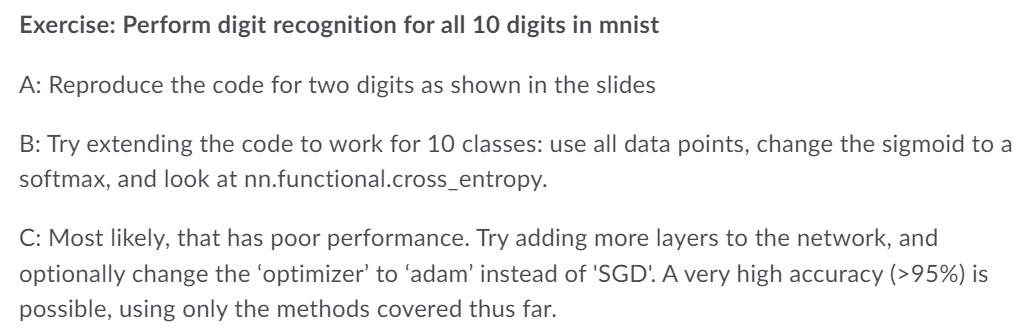

In [1]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#Sci-kit learn
import sklearn.model_selection

#Numpy
import numpy as np

#Matplotlib
import matplotlib.pyplot as plt

#Dataset
from mlxtend.data import mnist_data


In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    cuda = torch.device('cuda')
    print(torch.version.cuda)
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    t = torch.cuda.get_device_properties(0).total_memory
    print(t/1e6)
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    f = r-a
    print('reserved memory',r)
    print('allocated memory',a)
    print('free memory',f/1e6)
else:
    print('no cuda available')

11.8
0
1
NVIDIA GeForce RTX 4060 Laptop GPU
8585.216
reserved memory 0
allocated memory 0
free memory 0.0


In [3]:
print('current reserved memory: ', torch.cuda.memory_reserved(0))
print('current allocated memory: ', torch.cuda.memory_allocated(0))
print('available CUDA devices: ', torch.cuda.device_count())

current reserved memory:  0
current allocated memory:  0
available CUDA devices:  1


In [4]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Part A
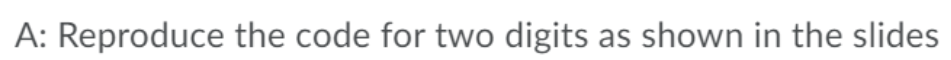

In [5]:
#load handwritten digits data
X,y = mnist_data()

#keep only 0's and 1's for binary classification
keep=(y==0) | (y==1)
X = X[keep,:]
y = y[keep]

In [6]:
#Split data in training and testing sets
Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)
trainDataset = torch.utils.data.TensorDataset(torch.tensor(Xtrain).float(),torch.tensor(ytrain).float())
testDataset = torch.utils.data.TensorDataset(torch.tensor(Xtest).float(),torch.tensor(ytest).float())

M,N = Xtrain.shape
print('Xtrain shape [M,N]:',[M,N])

Xtrain shape [M,N]: [700, 784]


In [7]:
#Making a neural network
class logRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer=nn.Linear(784,1, bias=True)
    def forward(self,x):
        x = self.inputLayer(x)
        x = torch.sigmoid(x)
        return torch.squeeze(x)


In [8]:
#quickly test network
#testData = torch.rand((20,784))
#testNet = logRegression()
#testNet.forward(testData)

In [9]:
#Setup training of network
nEpochs = 10
learningRate = 0.001
batchSize = 64

trainDataLoader = torch.utils.data.DataLoader(trainDataset,batch_size=batchSize,shuffle=True)
model = logRegression()
#model.to(cuda)
optimizer = torch.optim.SGD(model.parameters(),learningRate)

loss_fn = nn.BCELoss()

accuracy = np.zeros(nEpochs)

for iEpoch in range(nEpochs):
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    for xbatch, ybatch in trainDataLoader:
        #xbatch = xbatch.to(cuda)
        #ybatch = ybatch.to(cuda)
        y_pred = model(xbatch)
        loss = loss_fn(y_pred,ybatch)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        yhat=y_pred>0.5
        #estimatedLabels = np.append(estimatedLabels,torch.Tensor.cpu(yhat))
        #trueLabels = np.append(trueLabels,torch.Tensor.cpu(ybatch))
        estimatedLabels = np.append(estimatedLabels,yhat)
        trueLabels = np.append(trueLabels,ybatch)
    accuracy[iEpoch] = np.mean(estimatedLabels==trueLabels)

(0.0, 1.0)

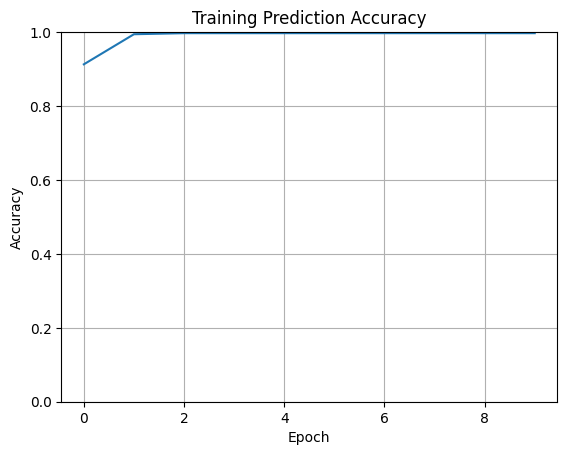

In [10]:
plt.plot(accuracy)
plt.title('Training Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0,1])

# Part B
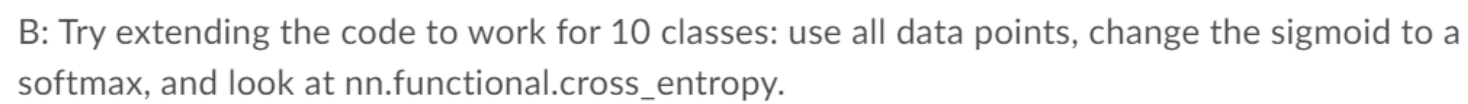

In [11]:
#load handwritten digits data - keep all digits
X,y = mnist_data()

In [12]:
#Split data in training and testing sets
Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)
trainDataset = torch.utils.data.TensorDataset(torch.tensor(Xtrain).float(),torch.tensor(ytrain).float())
testDataset = torch.utils.data.TensorDataset(torch.tensor(Xtest).float(),torch.tensor(ytest).float())

M,N = Xtrain.shape
print('Xtrain shape [M,N]:',[M,N])

Xtrain shape [M,N]: [3500, 784]


In [13]:
#Making a neural network
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer=nn.Linear(784,10, bias=True)
    def forward(self,x):
        x = self.inputLayer(x)
        m = nn.Softmax(dim=0)
        x = m(x)
        return torch.squeeze(x)

In [14]:
#Setup training of network
nEpochs = 200
learningRate = 0.0005
batchSize = 64

trainDataLoader = torch.utils.data.DataLoader(trainDataset,batch_size=batchSize,shuffle=True)
model = Net1()

#for cuda optimization
model.to(cuda)

optimizer = torch.optim.SGD(model.parameters(),learningRate)

loss_fn = nn.CrossEntropyLoss()

accuracy = np.zeros(nEpochs)

for iEpoch in range(nEpochs):
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    for xbatch, ybatch in trainDataLoader:
        
        #for cuda optimization
        xbatch = xbatch.to(cuda)
        ybatch = ybatch.to(cuda)
        
        #save original ybatch for accuracy calculation
        ybatch_o = ybatch.to(cuda,dtype=torch.int32)
        
        #model output will be probabilities of image fitting each class
        y_pred = model(xbatch)

        #cross entropy loss function between expected and model output
        loss = loss_fn(y_pred,ybatch.long())

        #reset gradient
        model.zero_grad()
        
        #backpropagation through neural network
        loss.backward()
        
        #optimizing weights
        optimizer.step()

        #determining accuracy
        [max_v, yhat] = torch.max(y_pred,dim=1)
        estimatedLabels = np.append(estimatedLabels,torch.Tensor.cpu(yhat))
        trueLabels = np.append(trueLabels,torch.Tensor.cpu(ybatch_o))

    accuracy[iEpoch] = np.mean(estimatedLabels==trueLabels)


(0.0, 1.0)

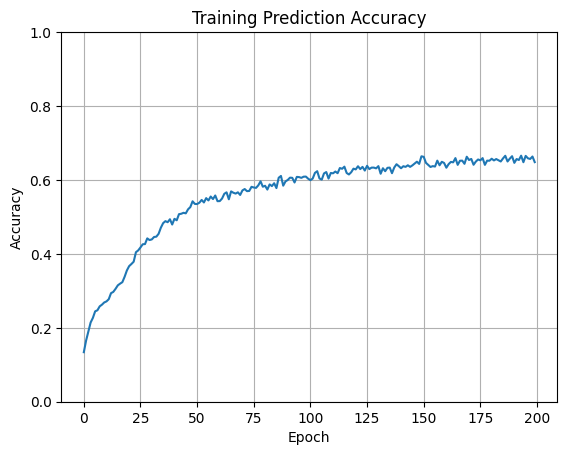

In [15]:
w = model.inputLayer.weight
plt.plot(accuracy)
plt.title('Training Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0,1])

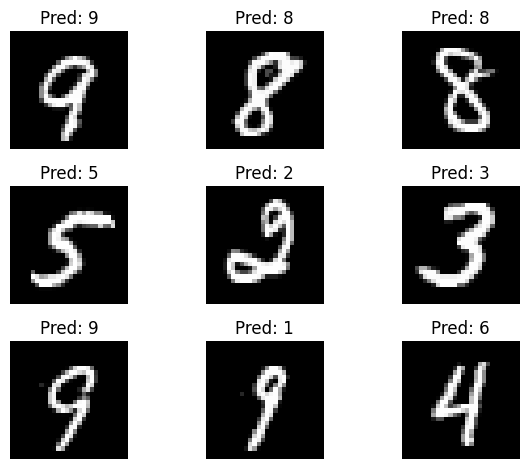

In [16]:
yh = torch.Tensor.cpu(yhat).numpy()
xb = torch.Tensor.cpu(xbatch).numpy()
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(np.reshape(xb[i,:],[28,28]),cmap='grey')
    ax.set_title('Pred: %i' %yh[i])
    ax.set_axis_off()
plt.tight_layout()

# Part C
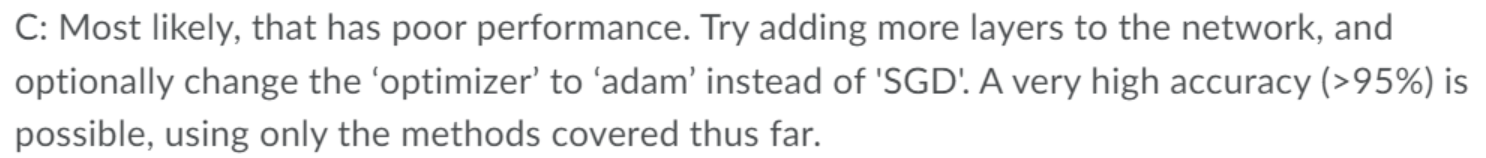

In [17]:
#Making a neural network 
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784,196, bias=True)
        self.linear2 = nn.Linear(196,49, bias=True)
        self.linear3 = nn.Linear(49,16, bias=True)
        self.linear4 = nn.Linear(16,10, bias=True)
        self.softmax = nn.Softmax(dim=0)
        self.ReLU = nn.ReLU()
    def forward(self,x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        x = self.ReLU(x)
        x = self.linear3(x)
        x = self.ReLU(x)
        x = self.linear4(x)
        x = self.softmax(x)
        return torch.squeeze(x)

In [44]:
#Setup training of network
nEpochs = 200
learningRate = 0.0002
batchSize = 64

trainDataLoader = torch.utils.data.DataLoader(trainDataset,batch_size=batchSize,shuffle=True)
model = Net2()

#for cuda optimization
model.to(cuda)

optimizer = torch.optim.Adam(model.parameters(),learningRate)

loss_fn = nn.CrossEntropyLoss()

accuracy = np.zeros(nEpochs)

for iEpoch in range(nEpochs):
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    for xbatch, ybatch in trainDataLoader:
        
        #for cuda optimization
        xbatch = xbatch.to(cuda)
        ybatch = ybatch.to(cuda)
        
        #save original ybatch for accuracy calculation
        ybatch_o = ybatch.to(cuda,dtype=torch.int32)

        #model output will be probabilities of image fitting each class
        y_pred = model(xbatch)

        #cross entropy loss function between expected and model output
        loss = loss_fn(y_pred,ybatch.long())

        #reset gradient
        model.zero_grad()
        optimizer.zero_grad()
        
        #backpropagation through neural network
        loss.backward()
        
        #optimizing weights
        optimizer.step()

        #determining accuracy
        [max_v, yhat] = torch.max(y_pred,dim=1)
        estimatedLabels = np.append(estimatedLabels,torch.Tensor.cpu(yhat))
        trueLabels = np.append(trueLabels,torch.Tensor.cpu(ybatch_o))
        #estimatedLabels = np.append(estimatedLabels,yhat)
        #trueLabels = np.append(trueLabels,ybatch_o)
    accuracy[iEpoch] = np.mean(estimatedLabels==trueLabels)


Training accuracy:  98.2 %


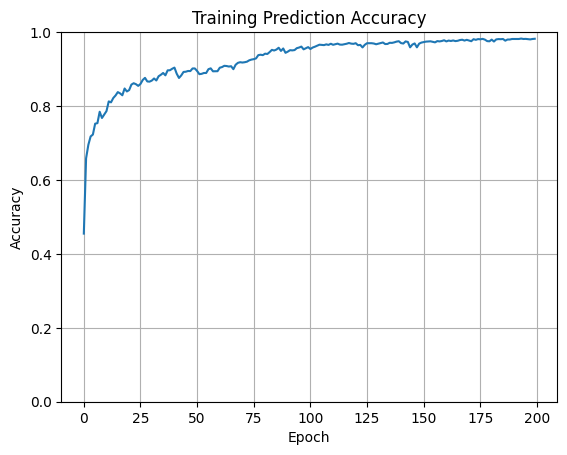

In [45]:
plt.plot(accuracy)
plt.title('Training Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0,1])
print('Training accuracy: ', accuracy[-1]*100,'%')

In [46]:
#test performance
testDataLoader = torch.utils.data.DataLoader(testDataset,batch_size=batchSize,shuffle=True)
estimatedLabels = np.empty((0,))
trueLabels = np.empty((0,))

for xbatch, ybatch in testDataLoader:
    #for cuda optimization
    xbatch = xbatch.to(cuda)
    ybatch = ybatch.to(cuda)
    
    #save original ybatch for accuracy calculation
    ybatch_o = ybatch.to(cuda,dtype=torch.int32)
    
    #onehot encoding the correct outputs
    ybatch = ybatch.long()
    ybatch = torch.Tensor(nn.functional.one_hot(ybatch, num_classes=10))
    ybatch = ybatch.to(dtype=torch.float32) #convert back to regular tensor

    #model output will be probabilities of image fitting each class
    y_pred = model(xbatch)

    #determining accuracy
    [max_v, yhat] = torch.max(y_pred,dim=1)
    estimatedLabels = np.append(estimatedLabels,torch.Tensor.cpu(yhat))
    trueLabels = np.append(trueLabels,torch.Tensor.cpu(ybatch_o))
    #estimatedLabels = np.append(estimatedLabels,yhat)
    #trueLabels = np.append(trueLabels,ybatch_o)
test_accuracy = np.mean(estimatedLabels==trueLabels)
print('test_accuracy = ',test_accuracy*100,'%')

test_accuracy =  93.53333333333333 %


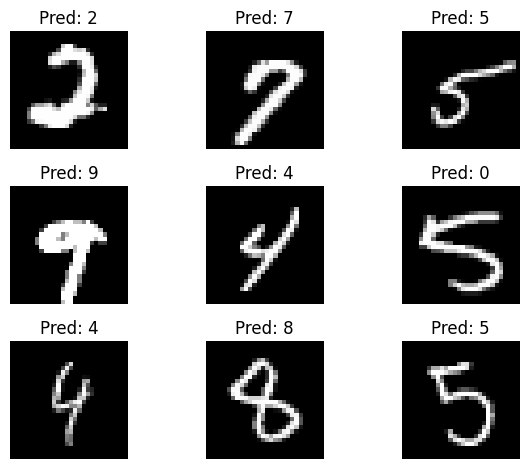

In [47]:
yh = torch.Tensor.cpu(yhat).numpy()
xb = torch.Tensor.cpu(xbatch).numpy()
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(np.reshape(xb[i,:],[28,28]),cmap='grey')
    ax.set_title('Pred: %i' %yh[i])
    ax.set_axis_off()
plt.tight_layout()